In [48]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from typing import Annotated, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
import os
from dotenv import load_dotenv

In [49]:
load_dotenv()

True

In [50]:
GROQ_API_KEY = os.environ.get('GROQ_API_KEY')

In [51]:
model = ChatGroq(model="llama-3.3-70b-versatile")

In [52]:
class ChatState(TypedDict):
    
    messages: Annotated[list[BaseMessage], add_messages]

In [53]:
def chat_node(state: ChatState):
    
    # take user query from the state
    messages = state['messages']
    
    # send the query to the model
    response = model.invoke(messages)
    
    # add the model response to the state
    return {'messages': [response]}

In [54]:
checkpointer = MemorySaver()

graph = StateGraph(ChatState)

graph.add_node('chat_node', chat_node)

graph.add_edge(START, 'chat_node')
graph.add_edge('chat_node', END)

workflow = graph.compile(checkpointer=checkpointer)

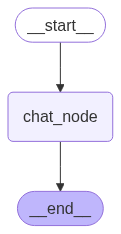

In [55]:
workflow

In [68]:
thread_id = '1'

initial_state = {
    "messages": [HumanMessage(content="Hello, how are you?")]
}

config = {'configurable': {'thread_id': thread_id}}

result = workflow.invoke(initial_state, config=config)

In [69]:
result['messages'][-1].content

"Hello once more, Hamza! I'm still doing well, thanks for asking. It's nice to see you're saying hello again. Is there something on your mind that you'd like to talk about, or would you like to play a game or have some fun? I'm all ears (or rather, all text)!"

In [58]:
thread_id = '1'

while True:
    
    user_input = input("You: ")
    
    print('User:', user_input)
    
    if user_input.strip().lower() in ['exit', 'quit', 'bye']:
        print("Exiting the chatbot.")
        break
    
    initial_state = {
        "messages": [HumanMessage(content=user_input)]
    }
    
    config = {'configurable': {'thread_id': thread_id}}
    
    result = workflow.invoke({'messages': [HumanMessage(content=user_input)]}, config=config)
    
    print("Chatbot:", result['messages'][-1].content)

User: add 100 to 300
Chatbot: 100 + 300 = 400
User: now add 200 to result
Chatbot: We had 400, and now we're adding 200:

400 + 200 = 600
User: bye
Exiting the chatbot.


In [59]:
workflow.get_state(config=config)

StateSnapshot(values={'messages': [HumanMessage(content='my name is hamza', additional_kwargs={}, response_metadata={}, id='628b6985-cd0a-4a07-bf59-899f9727d7cb'), AIMessage(content='Nice to meet you, Hamza! How are you doing today? Is there something I can help you with or would you like to chat?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 40, 'total_tokens': 70, 'completion_time': 0.054814234, 'prompt_time': 0.001715402, 'queue_time': 0.092304424, 'total_time': 0.056529636}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'stop', 'logprobs': None}, id='run--431ea87d-7a40-4772-bc9e-3a6d06e802d6-0', usage_metadata={'input_tokens': 40, 'output_tokens': 30, 'total_tokens': 70}), HumanMessage(content='what is my name', additional_kwargs={}, response_metadata={}, id='2a9920bf-b74d-432b-b559-1c5bef500a5c'), AIMessage(content='Your name is Hamza!', additional_kwargs={}, response_metadata